In [39]:
import re
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [2]:
# Libraries that may take forever to load
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
# nltk stuff
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/zacharyg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zacharyg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Plotly Configs
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


# Data Utility

In [5]:
with open('./non_stochastic_model_output.json', 'r') as file:
    data = json.load(file)

In [6]:
print(data.keys())

dict_keys(['articles', 'topics_filter', 'dates_filter', 'neighs_filter', 'tracts_filter'])


### To Pandas [articles]

In [7]:
list_of_articles = []

for article_key in data['articles'].keys():
    list_of_articles.append(data['articles'][article_key])

In [8]:
print(f"Amount of articles: {len(list_of_articles)}")

Amount of articles: 3023


In [9]:
list_of_articles[0]

{'neighborhoods': ['Fenway'],
 'position_section': 'Education',
 'tracts': ['010300'],
 'author': 'Esteban Bustillos',
 'body': 'Thomas White, a senior at Boston Latin School, is like a lot of high school athletes. A cross country runner, he trained hard all summer in hopes a season would happen.And, to his surprise, it did. But it wasn\'t without restrictions.“The state … didn’t really know what was safe or not safe. So everything kept getting pushed back," said White\'s coach, Chris Blondin. "And we were just praying that it wouldn’t end up like the spring season where it outright got cancelled. So the fact that we even have a season at all is just a blessing.”But then, in the last week of October, Boston Public Schools postponed the few athletic activities it was allowing, essentially killing the BLS season. It\'s just one example of the dark hole that high school sports have been thrown into during the pandemic. And even for the sports and districts that are still going, a season c

In [10]:
df_articles = pd.DataFrame(list_of_articles)

In [11]:
df_articles

,neighborhoods,position_section,tracts,author,body,content_id,hl1,hl2,pub_date,pub_name,link,openai_labels
0,[Fenway],Education,[010300],Esteban Bustillos,"Thomas White, a senior at Boston Latin School,...",00000175-7583-d779-a575-779f0f6b0001,"For High School Athletes, The Pandemic Has Led...","For High School Athletes, The Pandemic Has Led...",2020-11-11 00:00:00,GBH,https://wgbh.org/news/education/2020/11/11/for...,[]
1,"[Downtown, Beacon Hill]",Politics,"[981700, 020302]",Mike Deehan,A wave of blue votes could wash over the Massa...,00000175-75fe-d5c8-a775-f7fe5a7f0001,Mass. Republicans Don't Fear Trump-Fueled Blue...,Mass. Republicans Don't Fear Trump-Fueled Blue...,2020-11-03 00:00:00,GBH,https://wgbh.org/news/politics/2020/11/03/mass...,"[Elections, Candidates, Decision-making]"
2,"[Dorchester, Mattapan]",Politics,"[100900, 100700]",Adam Reilly,It’s unlikely Donald Trump will win Massachuse...,00000175-7aad-d944-a9fd-7aed30970002,Trump Won't Win Boston — But He Might Win This...,Trump Won't Win Boston — But He Might Win This...,2020-11-02 00:00:00,GBH,https://wgbh.org/news/politics/2020/11/02/trum...,[]
3,[Downtown],News,[030302],Craig LeMoult,The state Department of Public Health released...,00000175-7b20-d944-a9fd-7be1d4bf0001,Household 'Clusters' Are A Problem In Massachu...,Household 'Clusters' Are A Problem In Massachu...,2020-11-01 00:00:00,GBH,https://wgbh.org/news/local-news/2020/11/01/ho...,"[Disease Control, Prevention, Outbreak]"
4,[Jamaica Plain],Education,[120400],Kirk Carapezza,"A couple of years ago, Daymian Mejia, a senior...",00000175-7b24-d5c8-a775-fb2c49a40001,'A Tint Over Everything': College Students Of ...,'A Tint Over Everything': College Students Of ...,2020-11-10 00:00:00,GBH,https://wgbh.org/news/education/2020/11/10/a-t...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
3018,[Longwood],News,[081001],Craig LeMoult,The successful use of messenger RNA to create ...,00000185-4000-d153-afcd-6e55fe180001,Trial is now testing the promise of mRNA techn...,Trial is now testing the promise of mRNA techn...,2023-01-03 00:00:00,GBH,https://wgbh.org/news/local-news/2023/01/03/tr...,"[Disease Control, Prevention, Outbreak]"
3019,[Downtown],News,[070202],Mackenzie Farkus,Today on Boston Public Radio:We began the show...,00000185-409c-d153-afcd-6edd8ac80001,"Boston Public Radio full show: Dec. 23, 2022","Boston Public Radio full show: Dec. 23, 2022",2022-12-23 00:00:00,GBH,https://wgbh.org/news/local-news/2022/12/23/bo...,"[Music, Performances, Organizations]"
3020,[Downtown],News,[030302],Paul Singer,The holiday presents are unwrapped. So what do...,00000185-5049-d270-adb5-55db13350001,"In Boston, last week's wrapping paper cannot b...","In Boston, last week's wrapping paper cannot b...",2022-12-26 00:00:00,GBH,https://wgbh.org/news/local-news/2022/12/26/in...,"[Water Quality, Environmental Protection, Wast..."
3021,[East Boston],News,[981300],Adam Reilly,Updated at 5:36 p.m. Dec. 27SeparatorThe scene...,00000185-5505-d153-afcd-7f555b950001,"At Logan, stymied travelers seethe over Southw...","At Logan, stymied travelers seethe over Southw...",2022-12-27 00:00:00,GBH,https://wgbh.org/news/local-news/2022/12/27/at...,"[Airline Industry, Customer Service, Flight]"


In [12]:
df_articles.dtypes

neighborhoods       object
position_section    object
tracts              object
author              object
body                object
content_id          object
hl1                 object
hl2                 object
pub_date            object
pub_name            object
link                object
openai_labels       object
dtype: object

## Some Statistics on Article Bodies

In [13]:
def getNWordCounts(df_body):
    """
    Get the top counts given a list of strings.
    """
    body_np = df_body.to_numpy()
    one_giant_string_of_all_bodies = "".join(body_np)
    
    tokens = word_tokenize(one_giant_string_of_all_bodies)
    tokens = [word for word in tokens if word.isalpha()] # Remove punctuation
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english')) # Remove stuff like and, or, the etc.
    tokens = [word for word in tokens if word not in stop_words]
    tokens_np = np.array(tokens) # I need them back in np to do some np stuff...
    words, count = np.unique(tokens_np, return_counts=True)
    
    sorted_indices = np.argsort(count)[::-1] # Ascending order...
    sorted_words = words[sorted_indices]
    sorted_counts = count[sorted_indices]

    return sorted_words, sorted_counts
    

## Most Frequent Words Appeared in Different catagories

In [18]:
sorted_words_all_body, sorted_counts_all_body = getNWordCounts(df_articles['body'])

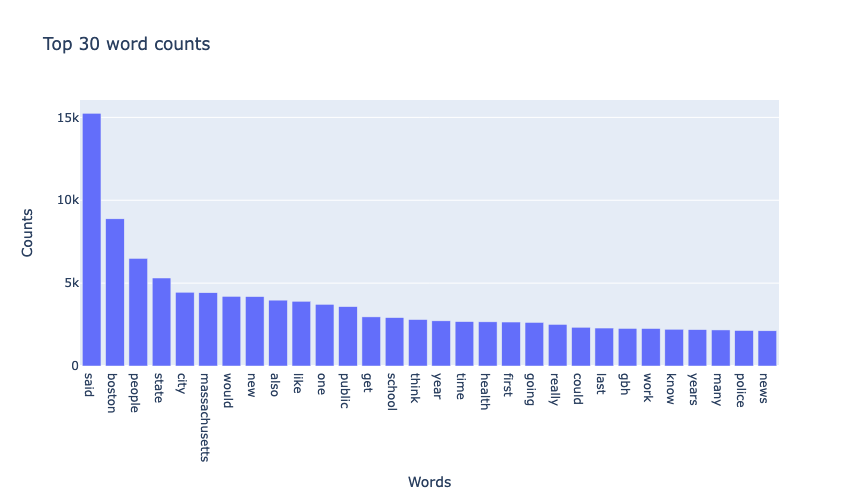

In [24]:
# Overall
n = 30
fig = go.Figure([go.Bar(
    x=sorted_words_all_body[:n], 
    y=sorted_counts_all_body[:n]
)])
fig.update_layout(
    title=f"Top {n} word counts", 
    xaxis_title="Words", 
    yaxis_title="Counts",
    height=500,
    width = 900
)

# Show the figure
fig.show()

Boston is the second most used words over all the bodies (approx. 8880 times).

In [15]:
df_articles['position_section'].unique()

array(['Education', 'Politics', 'News', 'Specials', 'Lifestyle', 'Arts',
       'Support', 'GBH Events'], dtype=object)

## Frequent Words per Category

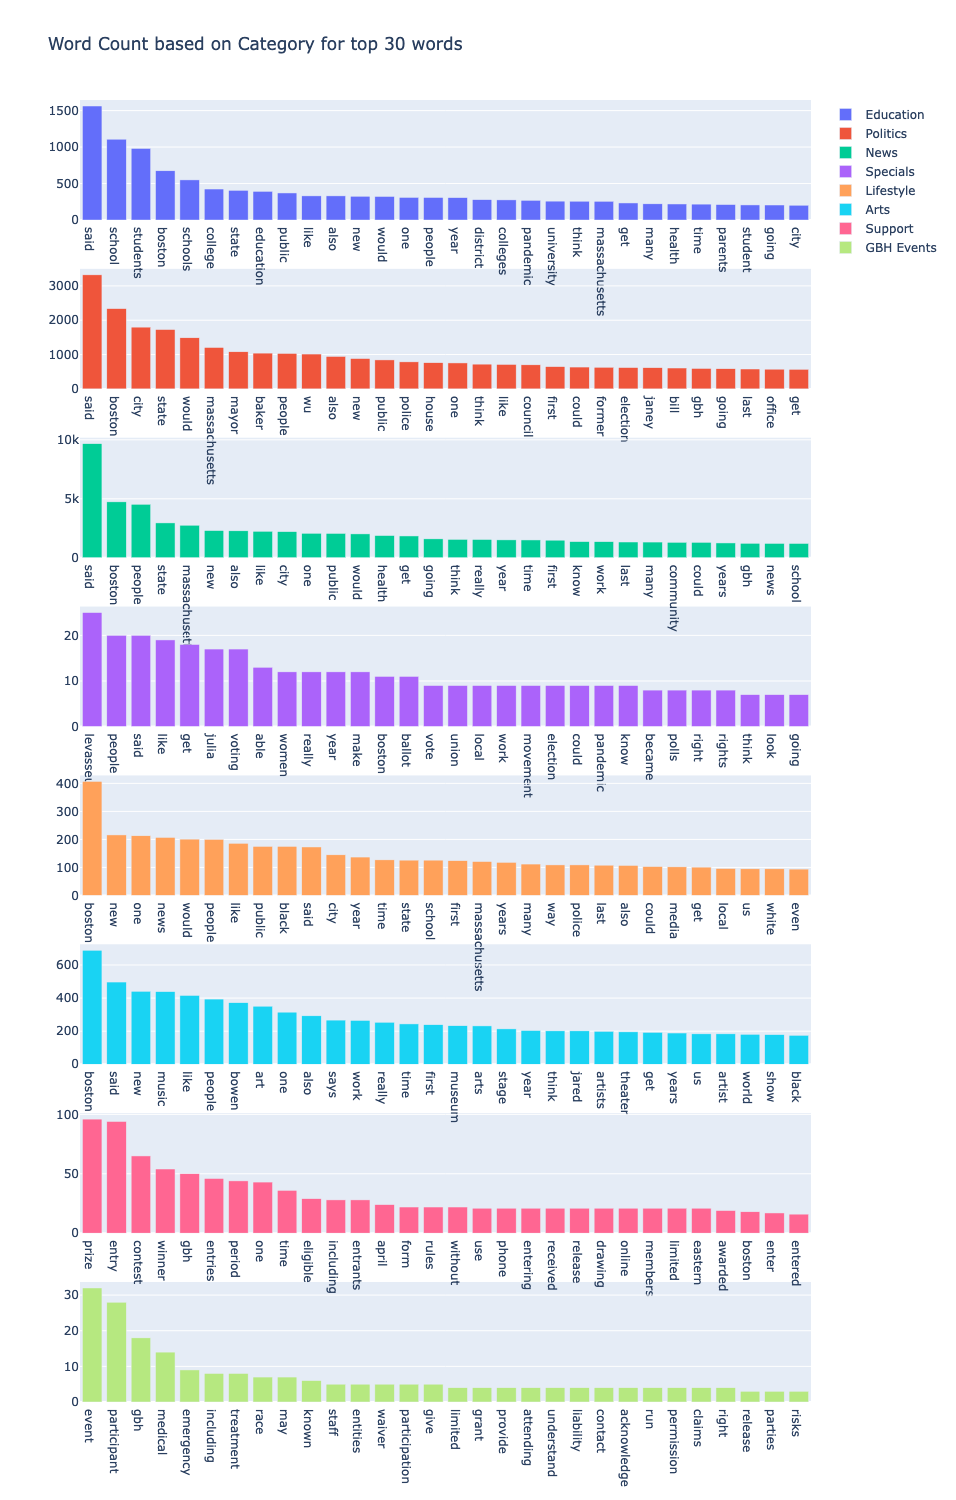

In [35]:
from plotly.subplots import make_subplots

unique_cats = df_articles['position_section'].unique()
fig = make_subplots(
    rows=len(unique_cats), 
    cols=1
)
row = 1
n = 30

for category in unique_cats:
    df_cat = df_articles[df_articles['position_section'] == category]['body']
    sorted_words, sorted_counts = getNWordCounts(df_cat)
    
    
    # Add the first bar chart to the first subplot
    fig.add_trace(
        go.Bar(
            x=sorted_words[:n], 
            y=sorted_counts[:n], 
            name=f'{category}'),
            row=row, 
            col=1
    )
    
    row += 1
    
    fig.update_layout(
        title_text=f"Word Count based on Category for top {n} words",
        height=1500
    )
    
fig.show()
    

## Sentence Context with Boston

In [36]:
body_np = df_articles['body'].to_numpy()
one_giant_string_of_all_bodies = "".join(body_np)

In [40]:
def split_by_sentence_stoppers(s):
    # Split by !, ?, ;, and . but also handle cases with spaces following these punctuation marks
    return [phrase.strip() for phrase in re.split(r'[!?.;]\s*', s) if phrase]
    
arr_sentences = split_by_sentence_stoppers(one_giant_string_of_all_bodies)

In [43]:
print(arr_sentences[:10])

['Thomas White, a senior at Boston Latin School, is like a lot of high school athletes', 'A cross country runner, he trained hard all summer in hopes a season would happen', 'And, to his surprise, it did', "But it wasn't without restrictions", '“The state … didn’t really know what was safe or not safe', 'So everything kept getting pushed back," said White\'s coach, Chris Blondin', '"And we were just praying that it wouldn’t end up like the spring season where it outright got cancelled', 'So the fact that we even have a season at all is just a blessing', '”But then, in the last week of October, Boston Public Schools postponed the few athletic activities it was allowing, essentially killing the BLS season', "It's just one example of the dark hole that high school sports have been thrown into during the pandemic"]


In [48]:
arr_sentences_boston = []

for sentence in arr_sentences:
    if ('Boston' in sentence or 'boston' in sentence):
        arr_sentences_boston.append(sentence)


In [50]:
print(arr_sentences_boston[:30])

['Thomas White, a senior at Boston Latin School, is like a lot of high school athletes', '”But then, in the last week of October, Boston Public Schools postponed the few athletic activities it was allowing, essentially killing the BLS season', 'It’s unlikely Donald Trump will win Massachusetts this week, and even more unlikely likely he’ll win Boston, where Hillary Clinton got 81 percent of the vote in 2016', 'Maureen Feeney, the former Boston City Councilor and current city clerk, has lived in the area in question — Ward 16, Precinct 12 — for half a century', '(On a map of Boston, it’s the city’s southeastern tip, right across the Neponset River from Quincy and Milton', '” If you’re an outsider and visit 16-12, you’ll probably notice Florian Hall, the headquarters for the Boston Firefighters Union', "Florian Hall, the headquarters of the Boston firefighter's union (side view)You might not see a single 'Donald Trump for President' sign", '“[Trump] didn’t win a single precinct in Boston

# Using Rule-Based Approach using Named Entity Recognition

The new approach should be:
<br>
Sentence Compression -> NER-BERT -> Optional post processing -> ChatGPT -> Google Maps API.

In [51]:
from transformers import pipeline, BertTokenizer, BertForTokenClassification
import torch

In [58]:
def contains_location(sentence, nlp_ner):    
    ner_results = nlp_ner(sentence)

    # Check for location entities
    for entity in ner_results:
        if entity['entity'] == 'B-LOC' or entity['entity'] == 'I-LOC': # B-LOC and I-LOC tags denote locations in CoNLL-03 format
            return True
    return False

In [59]:
# Load pre-trained NER pipeline
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", tokenizer="dbmdz/bert-large-cased-finetuned-conll03-english")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
sentences_with_location = [];
k = 100
for sentence in arr_sentences[:k]:
    if (contains_location(sentence, nlp_ner)):
        sentences_with_location.append(sentence)


In [77]:
print(len(arr_sentences))
print(len(sentences_with_location))

98609
28


In [80]:
non_loc_sentences = []
for x in arr_sentences[:k]:
    if (not x in sentences_with_location):
        non_loc_sentences.append(x)

for s in non_loc_sentences:
    print(s)
    print()

print("====== NER RESULTS SENTENCES ========")
print()

for s in sentences_with_location:
    print(s)
    print()

Thomas White, a senior at Boston Latin School, is like a lot of high school athletes

A cross country runner, he trained hard all summer in hopes a season would happen

And, to his surprise, it did

But it wasn't without restrictions

“The state … didn’t really know what was safe or not safe

So everything kept getting pushed back," said White's coach, Chris Blondin

"And we were just praying that it wouldn’t end up like the spring season where it outright got cancelled

So the fact that we even have a season at all is just a blessing

”But then, in the last week of October, Boston Public Schools postponed the few athletic activities it was allowing, essentially killing the BLS season

It's just one example of the dark hole that high school sports have been thrown into during the pandemic

And even for the sports and districts that are still going, a season can seem like a countdown to the inevitable postponement or cancellation

And for White, and other high school seniors like him, t

### Example of Reducing a body for ChatGPT Consumption

In [81]:
# Lets take this article
test_para = df_articles[df_articles["content_id"] == "00000175-8eb2-d779-a575-bebf9ad70001"]['body'].to_numpy()
print(test_para)

['It\'s Election Day, and some states continue to deal with questions around how and when votes will be counted. GBH Morning Edition host Joe Mathieu spoke with Northeastern University law professor and GBH News legal analyst Daniel Medwed to update us on some of the voting rights lititgation we\'ve seen this election season. The transcript below has been edited for clarity. Joe Mathieu: We spent a lot of time last week talking about Pennsylvania, the notorious swing state. Republicans are trying today to overturn a state court decision that would allow mail-in ballots to be received as late as this Friday as opposed to Election Day today. Has that been resolved, Daniel? Daniel Medwed: Well, fortunately, yes — for the time being, at least. Here\'s what happened. The state Republican Party filed multiple requests with the U.S. Supreme Court to overturn that state decision, but the Supreme Court thwarted those attempts, basically saying it was too close to the election [and] didn\'t want

In [83]:
test_sentence = split_by_sentence_stoppers(test_para[0])

In [115]:
# for s in test_sentence:
#     print(s)
#     print()

In [110]:
def constraints(sentence, nlp_ner):    
    ner_results = nlp_ner(sentence)

    # Check for location entities
    for entity in ner_results:
        # BIO scheme
        if (entity['entity'] == 'B-LOC' or 
            entity['entity'] == 'I-LOC' or
            entity['entity'] == 'B-ORG' or
            entity['entity'] == 'I-ORG'  
            # entity['entity'] == 'GPE' 
           ): # B-LOC and I-LOC tags denote locations in CoNLL-03 format
            return True
    return False

In [111]:
recognized_locs = [];
k = 100
for sentence in test_sentence:
    if (constraints(sentence, nlp_ner)):
        recognized_locs.append(sentence)

In [112]:
print(f"Amount of recognized locations: {len(recognized_locs)}")

Amount of recognized locations: 21


In [128]:
print(recognized_locs)

["GBH Morning Edition host Joe Mathieu spoke with Northeastern University law professor and GBH News legal analyst Daniel Medwed to update us on some of the voting rights lititgation we've seen this election season", 'Joe Mathieu: We spent a lot of time last week talking about Pennsylvania, the notorious swing state', 'The state Republican Party filed multiple requests with the U', "Supreme Court to overturn that state decision, but the Supreme Court thwarted those attempts, basically saying it was too close to the election [and] didn't want to meddle in state voting law", "What's alarming about the decision, though, at least for those of us who are really concerned about protracted post-election litigation, is that three justices — Alito, Gorsuch and Thomas — hinted that they thought this lawsuit had merit [and] that the Pennsylvania Supreme Court usurped the authority of the state legislature when it pushed back the deadline for receiving mail-in ballots", "And some people think that

In [116]:
regular_sentences = []

for s in test_sentence:
    if (s not in recognized_locs):
        regular_sentences.append(s);

In [117]:
print(regular_sentences)

["It's Election Day, and some states continue to deal with questions around how and when votes will be counted", 'The transcript below has been edited for clarity', 'Republicans are trying today to overturn a state court decision that would allow mail-in ballots to be received as late as this Friday as opposed to Election Day today', 'Has that been resolved, Daniel', 'Daniel Medwed: Well, fortunately, yes — for the time being, at least', "Here's what happened", 'S', 'Mathieu: We talked about "naked ballots" last week', 'You mentioned that a state requires voters to submit mail-in ballots in a security sleeve', "If you don't, they're naked", "they don't count", "We've seen estimates, Daniel, that could affect thousands of votes", 'What do you think of that', "Medwed: Well, that's right", "they won't be tabulated", 'And that could, as you point out, jeopardize up to 100,000 votes', "That's the estimate I've seen", 'You can come down to your polling place today and file a provisional ball

## Sentence Compression

In [153]:
import spacy

nlp = spacy.load("en_core_web_sm")

def compress_sentence(sentence):
    doc = nlp(sentence)

    # Extract main subject, verb, and object
    subject, verb, obj = '', '', ''
    for token in doc:
        if "subj" in token.dep_:
            subject = token.text
        if "obj" in token.dep_:
            obj = token.text
        if token.pos_ == "VERB":
            verb = token.text

    # Extract named entities
    entities = ' '.join([ent.text for ent in doc.ents])

    # Combine extracted elements
    compressed = ' '.join([entities, subject, verb, obj]).strip()
    return compressed

In [156]:
sentence = "It's Election Day, and some states continue to deal with questions around how and when votes will be counted."

for s in regular_sentences:
    compressed = compress_sentence(s)
    if (len(compressed.split()) <= 3):
        continue
    print(f"Uncompressed by spaCy: {s}")
    print()
    print(f"Compressed: {compress_sentence(s)}")
    print("====")

Uncompressed by spaCy: It's Election Day, and some states continue to deal with questions around how and when votes will be counted

Compressed: Election Day votes counted questions
====
Uncompressed by spaCy: Republicans are trying today to overturn a state court decision that would allow mail-in ballots to be received as late as this Friday as opposed to Election Day today

Compressed: Republicans today this Friday Election Day ballots opposed Day
====
Uncompressed by spaCy: Mathieu: We talked about "naked ballots" last week

Compressed: last week We talked ballots
====
Uncompressed by spaCy: We've seen estimates, Daniel, that could affect thousands of votes

Compressed: Daniel thousands that affect votes
====
Uncompressed by spaCy: And that could, as you point out, jeopardize up to 100,000 votes

Compressed: up to 100,000 you jeopardize votes
====
Uncompressed by spaCy: You can come down to your polling place today and file a provisional ballot

Compressed: today You file ballot
===